# Extracting and filtering result lists from SIRIUS using functional metabolomics

## requirements
- python
- rdkit
- pandas
- py-sirius-ms

All libraries can be installed via conda-forge or pip.

## Processing MGF files with functional metabolomics information in SIRIUS

- Drag&Drop the MGF files into SIRIUS
- Click on **compute all** and perform at least SIRIUS, CSI:FingerID and Structure Database search. ZODIAC is optional.
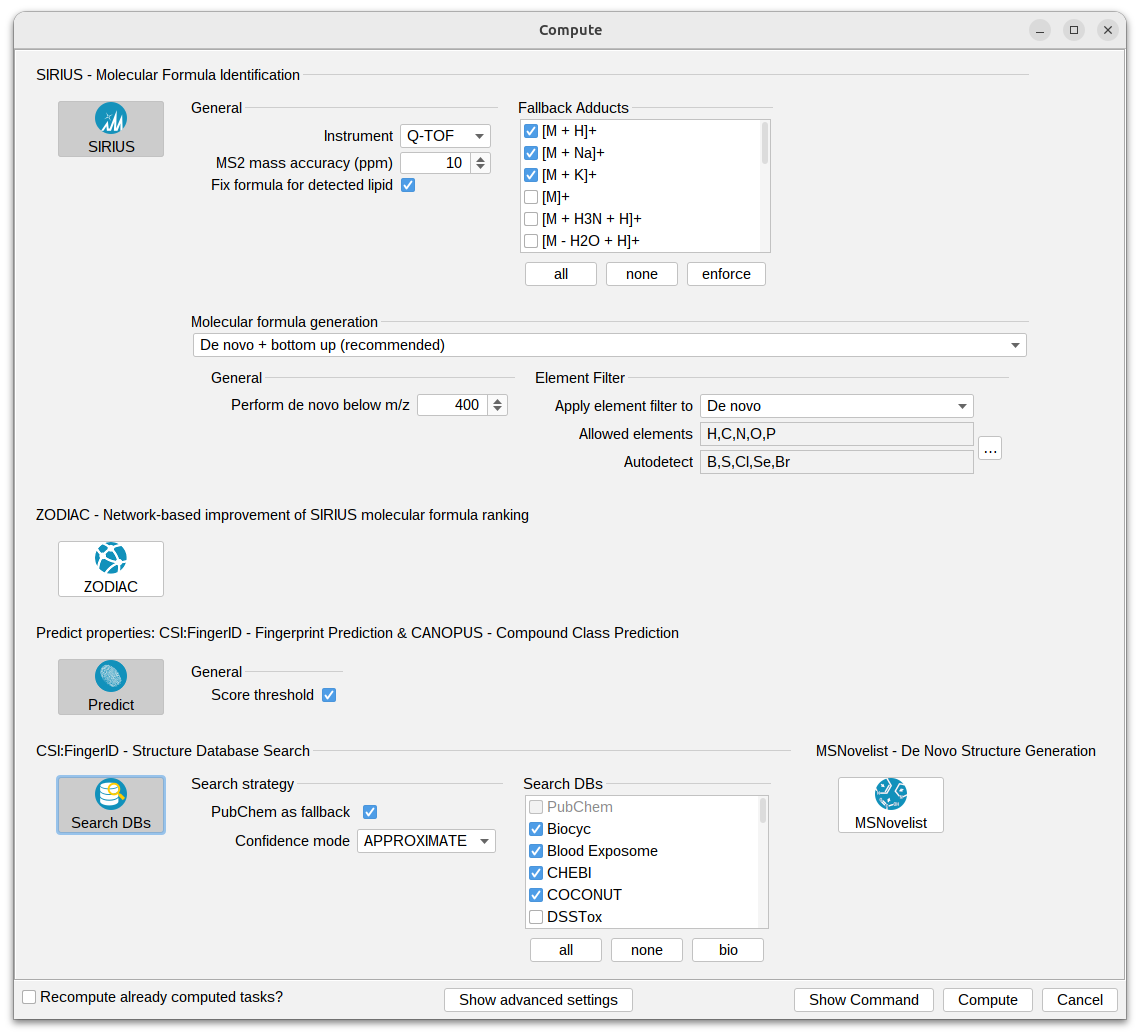

# Extract result lists from SIRIUS

- it is recommended but not mandatory to save the project space via **save as**
- Keep the SIRIUS window open and execute the Jupyter Notebook


# Connecting to SIRIUS SDK
First we connect to the running SIRIUS instance. For this it is important the the SIRIUS window is still opened. 

For those who are running SIRIUS in terminal without UI, you can start SIRIUS with the following options:
`sirius -p path/to/projectspace rest`

The following code will connect with the running SIRIUS via REST API and access the project space.


In [30]:
from PySirius import SiriusSDK
sdk = SiriusSDK()
# SIRIUS must be in the path or the SIRIUS_EXE environment variable must be specified.
# Is automatically configured when installing via conda or windows ms installer
api = sdk.attach_or_start_sirius()

Attached to running SIRIUS instance.


In [31]:
ps = api.projects().get_project_spaces()[0]
PROJECT_SPACE_ID = ps.project_id

Next, we will read all compounds with annotated structures from the SIRIUS project space

In [32]:
features = api.features().get_aligned_features(project_id=PROJECT_SPACE_ID, opt_fields=["computedTools"])
features_with_structures = [(feature.aligned_feature_id, feature.name) for feature in features if feature.computed_tools.structure_search]

This class will manage the filtering via SMARTS and export as pandas dataframe

In [33]:
import rdkit
from rdkit.Chem import MolFromSmiles, InchiToInchiKey, MolFromSmarts, AddHs
from rdkit.Chem.inchi import MolToInchiKey, MolToInchi
import pandas
class Compound():
    def __init__(self, feature_id, internal_id, structure_candidates, smarts_rules=[]):
        self.feature_id = feature_id
        self.internal_id = internal_id
        self.structure_candidates = structure_candidates
        self.smarts_rules = smarts_rules   

    def to_dataframe(self, apply_filter=False):
        rows = self.__apply_smarts__()
        rank=1
        for row in rows:
            if row[0]:
                row.append(str(rank))
                rank+=1
            else:
                row.append("N/A")
        if apply_filter:
            rows = [r for r in rows if r[0]]
        
        return pandas.DataFrame(
            data={
                "feature_id": [self.feature_id for _ in rows],
                "sirius_feature_id": [self.internal_id for _ in rows],
                "smiles": [r[2].smiles for r in rows],
                "inchi_key_2d": [r[2].inchi_key for r in rows],
                "structure_name": [r[2].structure_name for r in rows],
                "csi_fingerid_score": [r[2].csi_score for r in rows],
                "molecular_formula_annotation": [r[2].molecular_formula for r in rows],
                "adduct_annotation": [r[2].adduct for r in rows],
                "satisfies_all_rules": ["yes" if r[0] else "no" for r in rows],
                "matching_smarts_patterns": [",".join(r[1]) for r in rows],
                "original_rank": [r[2].rank for r in rows],
                "filtered_rank": [r[3] for r in rows]
            }
        )
        
    def __apply_smarts__(self):
        if len(self.smarts_rules)==0:
            return [[True, [], s] for s in self.structure_candidates]
        candidates=[]
        smart_patterns = [MolFromSmarts(r) for r in self.smarts_rules]
        for candidate in self.structure_candidates:
            mol = AddHs(MolFromSmiles(candidate.smiles))
            matching_rules = [r for r in [r if mol.GetSubstructMatch(s) else None for (s,r) in zip(smart_patterns, self.smarts_rules)] if r is not None]
            candidates.append([len(matching_rules)>0, matching_rules, candidate])
        return candidates

We convert all compounds from the project space into instances of the Compound class. However, so far we do not have the SMARTS pattern, which are still in the original MGF files.

In [34]:
compounds = [Compound(name, feature_id, api.features().get_structure_candidates(project_id=PROJECT_SPACE_ID, aligned_feature_id=feature_id)) for (feature_id, name) in features_with_structures]
compounds_by_id = {c.feature_id: c for c in compounds}

This two functions will read the MGF file and search for all compounds with a functional metabolomics annotation. The corresponding compound from the SIRIUS project space (with same feature id) will be annotated with the functional metabolomics annotation. 

In [35]:
def parseMGF(filename):
    currentId = None
    currentSmarts = None
    with open(filename, "r") as fhandle:
        for line in fhandle:
            if line.startswith("BEGIN IONS"):
                currentId = None
                currentSmarts = None
            elif line.startswith("FEATURE_ID"):
                currentId = line.split("=",1)[1].strip()
            elif line.startswith("ONLINE_REACTIVITY"):
                currentSmarts = line.split("=",1)[1].strip()
            elif line.startswith("END IONS"):
                if currentId is not None and currentSmarts is not None:
                    yield(currentId, currentSmarts)

import json
def extractRules(compound_id, smarts):
    js=json.loads(smarts)
    rules = list({j["educt_smarts"] for j in js})
    if compound_id in compounds_by_id:
        compounds_by_id[compound_id].smarts_rules = rules

In [36]:
for (id, rules) in parseMGF("32mix_cysteine_SIRIUS.mgf"):
    extractRules(id,rules)

We can now export all compound result lists as dataframes and either store them separately

In [37]:
for compound in compounds:
    compound.to_dataframe().to_csv("%s.csv" %compound.feature_id)

Or we merge them all into one big dataframe and export that

In [38]:
huge_table = pandas.concat([compound.to_dataframe() for compound in compounds])
huge_table.to_csv("all.csv")